In [1]:
import sys
(sys.path).insert(1,'/Users/pedroguicardi/Desktop/CMB_Analysis/MAPSIMS/directories')

import mapsims
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import healpy as hp
import matplotlib
from matplotlib import pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from ad_fns import *
from astropy.io import fits
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ccat_models import ccat_noise as CCAT_noise
import scipy.optimize as op

passed


In [31]:
NSIDE = 512
ell_cutoff = False
lat_lmax = 5000
cmb = mapsims.SOPrecomputedCMB(
    num=2,
    nside=NSIDE,
    lensed=False,
    aberrated=False,
    has_polarization=True,
    cmb_set=0,
    cmb_dir="mapsims/tests/data",
    input_units="uK_CMB",
)

In [32]:
chs = ["tube:LC1","tube:LC2","tube:LC3"]
noise = mapsims.SONoiseSimulator(
        nside=NSIDE,
        return_uK_CMB = True,
        sensitivity_mode = "baseline",
        apply_beam_correction = False,
        apply_kludge_correction = False,
        homogeneous=False,
        rolloff_ell = 50,
        ell_max = lat_lmax,
        survey_efficiency = 1.0,
        full_covariance = False,
        LA_years = 5,
        LA_noise_model = "CcatLatv2b",
        elevation = 50,
        SA_years = 5,
        SA_one_over_f_mode = "pessimistic"
    )
output_maps = []
noise_maps = []
pspec_list = []
for ch in chs:
    
    
    noise_map = noise.simulate(ch[5:])
    noise_maps.append(noise_map)
    ell_sim, ps_T, ps_P, fsky, wnoise_power, weightsMap = noise.get_noise_properties(ch[5:])
    pspec_list.append(ps_T[:-1])
    
    pysm_string = "s0,d0"
    
    filename = ch[5:]+"_NSIDE_" + str(NSIDE) + "_TAG_" + pysm_string  +".fits"
    simulator = mapsims.MapSim(
        channels=ch,
        nside=NSIDE,
        unit="uK_CMB",
        pysm_output_reference_frame="C",
        pysm_components_string=pysm_string,
        output_filename_template = filename,
        pysm_custom_components={"cmb": cmb},
        other_components={"noise": noise},
    )
    output_map_full = simulator.execute()
    write_output_map(output_map_full,"output",filename)
    output_map_full = read_output_map("output",filename,noise, ch)
    output_maps.append(output_map_full)
    

output_maps = np.array(output_maps)
noise_maps = np.array(noise_maps).reshape(output_maps.shape)
pspec_list = np.array(pspec_list)
print(output_maps.shape)
print(noise_maps.shape)
print(pspec_list.shape)

(<Quantity 222. GHz>, array([1.]))
1.0 arcmin


(<Quantity 280. GHz>, array([1.]))
0.8 arcmin


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


(<Quantity 348. GHz>, array([1.]))
0.6 arcmin
(<Quantity 405. GHz>, array([1.]))
0.5 arcmin


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


(<Quantity 850. GHz>, array([1.]))
0.3 arcmin
(<Quantity 850. GHz>, array([1.]))
0.3 arcmin


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


(3, 2, 3, 3145728)
(3, 2, 3, 3145728)
(3, 2, 5000)


In [1]:
output_maps = np.array([output_maps[0,0],output_maps[0,1],output_maps[1,0],output_maps[1,1],output_maps[2,0]])
noise_maps = np.array([noise_maps[0,0],noise_maps[0,1],noise_maps[1,0],noise_maps[1,1],noise_maps[2,0]])
pspec_list = np.array([pspec_list[0,0],pspec_list[0,1],pspec_list[1,0],pspec_list[1,1],pspec_list[2,0]])
det_labels = ["222.0", "280.0","348.0", "405.0","850.0"]
print(pspec_list.shape)

NameError: name 'np' is not defined

In [34]:
for i in np.arange(output_maps.shape[0]):
    for j in np.arange(output_maps.shape[1]):
        output_maps[i][j] = apodize_map(output_maps[i,j], n_itp=5)

In [49]:
import pysm3
import pysm3.units as u
bandpass_list = [noise.tubes['LC1'][0].bandpass,noise.tubes['LC1'][1].bandpass, noise.tubes['LC2'][0].bandpass,noise.tubes['LC2'][1].bandpass,noise.tubes['LC3'][0].bandpass]
print(bandpass_list)
pysm_sky = pysm3.Sky(
                nside=NSIDE,
                preset_strings=["s0","d0"],
                component_objects=[])

pysm_map = pysm_sky.get_emission(*bandpass_list[0])
print(pysm_map.shape)

[(<Quantity 222. GHz>, array([1.])), (<Quantity 280. GHz>, array([1.])), (<Quantity 348. GHz>, array([1.])), (<Quantity 405. GHz>, array([1.])), (<Quantity 850. GHz>, array([1.]))]
(3, 3145728)


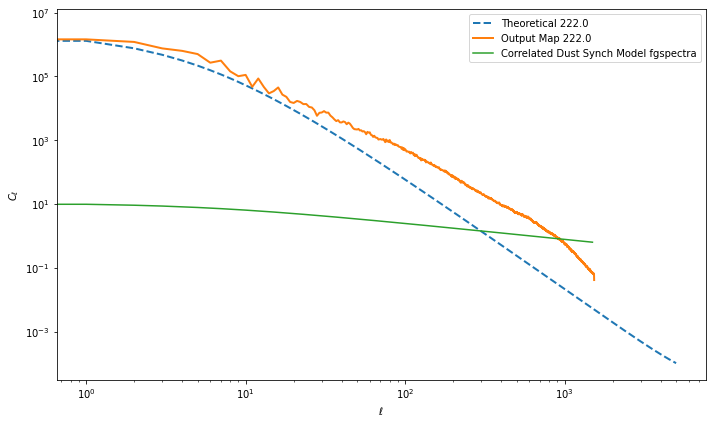

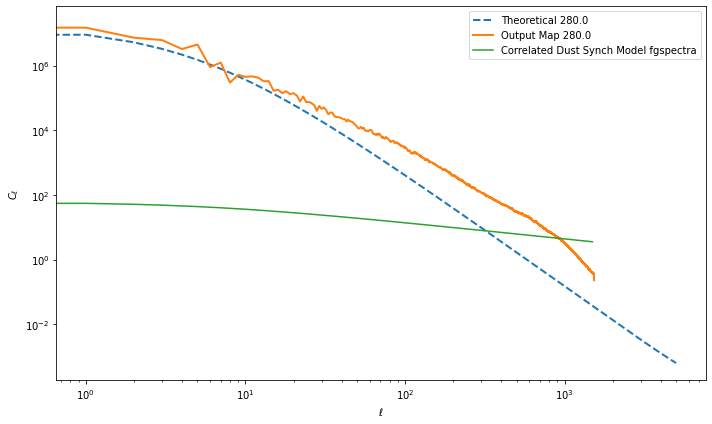

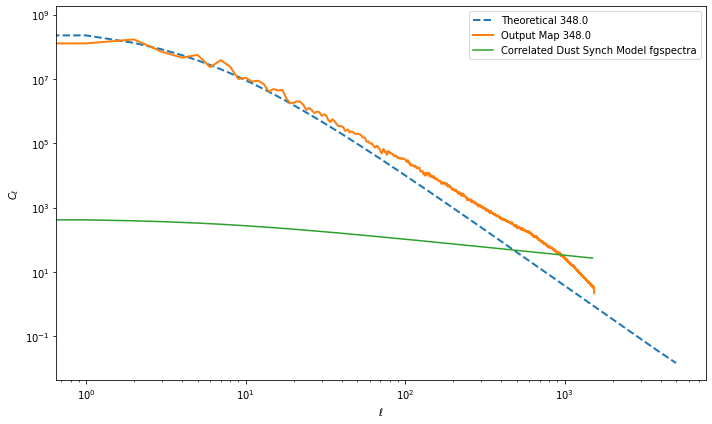

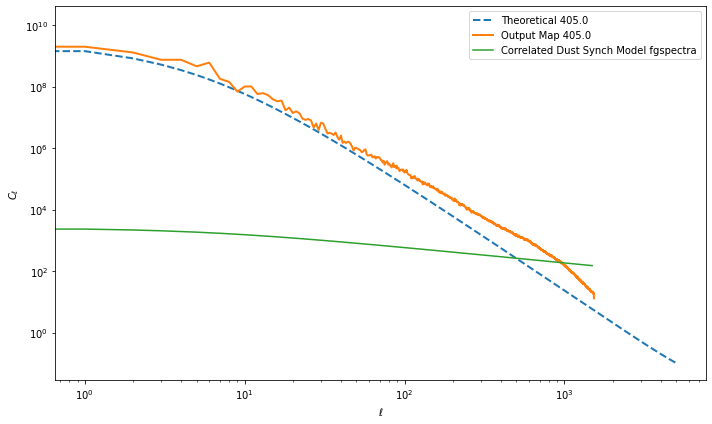

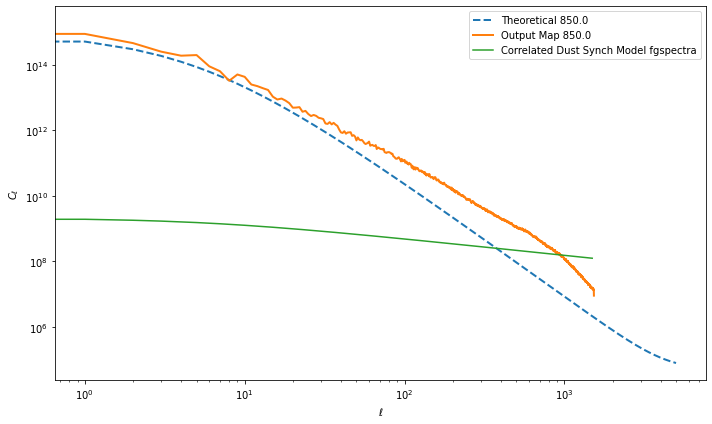

<Figure size 720x432 with 0 Axes>

In [37]:
plt.rcParams["figure.figsize"] = (10,6)
import fgspectra.cross as fgc
nu = np.array([222.0, 280.0, 348.0, 405.0, 850.0])
dust_params = dict(nu=nu, beta=1.54, temp=19.6, nu_0=353.)
sync_params = dict(nu=nu, beta=-3.15, nu_0=23.)
frequency_params = dict(kwseq=(dust_params, sync_params))

power_params = dict(
    ell=np.arange(1500)[1:],
    alpha=np.array([-2.51, -3.]) + 2,  # +2 to (almost) get D_ell
    ell_0=84,
    amp=np.array([137.0, 0.6]),
    rho=0.17
)

dust_sync = fgc.CorrelatedDustSynchrotron()

cl = dust_sync(frequency_params, power_params)


bands = np.array([222., 280., 348., 405., 850.])
w  = get_w(output_maps[0,0])

for i in np.arange(output_maps.shape[0]):
    cls_map = hp.sphtfunc.anafast(output_maps[i,0])/w
    plt.plot(pspec_list[i][5:],linewidth=2,label='Theoretical '+str(bands[i]),linestyle='--')
    #plt.plot(cls_map-pspec_list[i][:cls_map.shape[0]],linewidth=2,label='Output Map '+str(bands[i]))
    plt.plot(cls_map[5:],linewidth=2,label='Output Map '+str(bands[i]))
    plt.plot(cl[i,i][5:], label = 'Correlated Dust Synch Model fgspectra')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$C_{\ell}$')
    plt.xlabel(r'$\ell$')
    plt.show()
    plt.clf()

cls_cmb = hp.alm2cl(cmb.alm)
#plt.plot(cls_cmb[0],linewidth=2,label='CMB')

